# Model Experimentation & Interpretation

This notebook documents the core of our predictive modeling efforts for the Proactive Customer Retention project. Building on the cleaned and analyzed dataset from our Exploratory Data Analysis, our objective here is to build a complete, end-to-end system that moves from prediction to interpretation to action.

We will accomplish this through a four-step process:
1. Model Bake-Off: Conduct a structured "bake-off" to train and rigorously evaluate a diverse lineup of powerful classification models. This ensures our final model choice is not just high-performing but also robust and well-justified.
2. Champion Model Selection: Select the single best model based on metrics that are directly relevant to the business goal of identifying at-risk customers.
3. Explainable AI (XAI) with SHAP: Use the state-of-the-art SHAP (SHapley Additive exPlanations) library to translate our champion model's "black box" logic into clear, human-understandable insights. We will answer not just who will churn, but why.
4. Actionable Loyalty Profiles: Synthesize these SHAP insights into data-driven customer personas. This segmentation will form the strategic foundation for the personalized retention emails in Part II of our project.

### Algorithms:

- Random Forest: A powerful and robust ensemble model that serves as a strong baseline, less prone to overfitting than a single decision tree.
- XGBoost (Extreme Gradient Boosting): The industry gold standard for structured, tabular data. It is an advanced ensemble technique known for its exceptional performance and efficiency.
- Deep Neural Network (DNN): A deep learning approach designed to capture complex, non-linear patterns in the data. 

### Evaluation Strategy
Due to class imbalance, we prioritize metrics beyond Accuracy:

- AUC-ROC: Overall separability.

- Recall (Churn class): Critical for retention impact.

- Precision (Churn class): For false positives analysis.

- F1-Score (Churn class): Balanced effectiveness.

## Part 1: Model Experimentation

### 1. Imports and Setup

In [1]:
random_state = 7 # for reproducibility

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier # New
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score


2025-08-19 11:54:05.310715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755604445.325897   37684 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755604445.330494   37684 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755604445.343102   37684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755604445.343119   37684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755604445.343121   37684 computation_placer.cc:177] computation placer alr

In [3]:
# Ensure the directory existence
os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)

### 2. Data Loading and Preparation

In [ ]:
df = pd.read_csv('..\\data\\Vodafone_Customer_Churn_Sample_Dataset.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
columns_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies']

for column in columns_to_replace:
    df[column] = df[column].replace({'Yes': 1, 'No': 0, 'No internet service': 0})
    
df.drop('customerID', axis=1, inplace=True)

X = df.drop('Churn', axis=1)
y = df['Churn']

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()


# === Preprocessing Pipeline ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)


### 3. Model Training

This code constructs and trains three distinct machine learning models for a binary classification task (customer churn prediction), each with a specific strategy to handle class imbalance.

**Random Forest**

The Random Forest model is an ensemble learning method that creates multiple decision trees using different subsets of the data and features. By averaging the predictions from these trees, it effectively reduces overfitting. The model described uses 200 trees and a balanced class weighting to address imbalanced data, ensuring a reliable performance with minimal tuning.

**XGBoost**

XGBoost is a powerful and fast gradient boosting framework that builds decision trees sequentially. Each new tree in the sequence is designed to correct the errors of the preceding one. This specific implementation uses the scale_pos_weight parameter to focus on the minority class in an imbalanced dataset, and it incorporates regularization and handles missing data efficiently to achieve high performance.

**Neural Network**

This is a multilayer perceptron model designed to learn complex, non-linear patterns. It has an architecture with two hidden layers, containing 64 and 32 neurons, respectively. The model uses Batch Normalization and Dropout layers to prevent overfitting. It is trained with a specific optimizer and custom class weights for imbalanced data, and it includes automated callbacks for early stopping and dynamic learning rate reduction to optimize its performance.

In [5]:
# --- Model 1: Random Forest ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=random_state,
                                                                    class_weight='balanced',
                                                                    n_estimators=200))])
print("Training Random Forest model...")
rf_pipeline.fit(X_train, y_train)
print("Done.\n")

# --- Model 2: XGBoost (Industry Standard) ---
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(booster ='gbtree',
                                                            n_estimators=200,
                                                            random_state=random_state,
                                                            use_label_encoder=False, 
                                                            eval_metric='logloss', scale_pos_weight=scale_pos_weight))])
print("Training XGBoost model...")
xgb_pipeline.fit(X_train, y_train)
print("Done.\n")

# --- Model 3: Neural Network ---
X_train_processed = rf_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_processed = rf_pipeline.named_steps['preprocessor'].transform(X_test)
input_shape = X_train_processed.shape[1]

def nn_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'), BatchNormalization(), Dropout(0.4),
        Dense(32, activation='relu'), BatchNormalization(), Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

nn_model = nn_model(input_shape)
class_weight_0 = (1 / y_train.value_counts()[0]) * (len(y_train) / 2.0)
class_weight_1 = (1 / y_train.value_counts()[1]) * (len(y_train) / 2.0)
nn_class_weights = {0: class_weight_0, 1: class_weight_1}

early_stopping = EarlyStopping(monitor='val_auc', patience=25, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=5, min_lr=0.00001, mode='max')

print("\nTraining Neural Network model...")
history = nn_model.fit(X_train_processed, y_train, epochs=200, batch_size=32, validation_split=0.2,
                                class_weight=nn_class_weights, callbacks=[early_stopping, reduce_lr], verbose=0)
print("Done. Model training stopped at epoch:", early_stopping.stopped_epoch)

Training Random Forest model...
Done.

Training XGBoost model...
Done.



2025-08-19 11:54:08.947888: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Training Neural Network model...
Done. Model training stopped at epoch: 38


### 4. Model Evaluation

In [6]:
# Get predictions
rf_preds = rf_pipeline.predict(X_test)
xgb_preds = xgb_pipeline.predict(X_test)
nn_preds_proba = nn_model.predict(X_test_processed).flatten()
nn_preds = (nn_preds_proba > 0.5).astype(int)

# Get prediction probabilities for AUC
rf_preds_proba = rf_pipeline.predict_proba(X_test)[:, 1]
xgb_preds_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# Store results in a dictionary
results = {
    'Random Forest': {
        'AUC': roc_auc_score(y_test, rf_preds_proba),
        'F1 (Churn)': f1_score(y_test, rf_preds, pos_label=1),
        'Recall (Churn)': recall_score(y_test, rf_preds, pos_label=1),
        'Precision (Churn)': precision_score(y_test, rf_preds, pos_label=1)
    },
    'XGBoost': {
        'AUC': roc_auc_score(y_test, xgb_preds_proba),
        'F1 (Churn)': f1_score(y_test, xgb_preds, pos_label=1),
        'Recall (Churn)': recall_score(y_test, xgb_preds, pos_label=1),
        'Precision (Churn)': precision_score(y_test, xgb_preds, pos_label=1)
    },
    'Neural Network': {
        'AUC': roc_auc_score(y_test, nn_preds_proba),
        'F1 (Churn)': f1_score(y_test, nn_preds, pos_label=1),
        'Recall (Churn)': recall_score(y_test, nn_preds, pos_label=1),
        'Precision (Churn)': precision_score(y_test, nn_preds, pos_label=1)
    }
}

# Print the results
print("\n" + "="*60)
print("              Final Model Performance")
print("="*60)
for model_name, metrics in results.items():
    print(f"\n--- {model_name} ---")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
print("="*60)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

              Final Model Performance

--- Random Forest ---
AUC: 0.8409
F1 (Churn): 0.5723
Recall (Churn): 0.4866
Precision (Churn): 0.6947

--- XGBoost ---
AUC: 0.8245
F1 (Churn): 0.5955
Recall (Churn): 0.6417
Precision (Churn): 0.5556

--- Neural Network ---
AUC: 0.8559
F1 (Churn): 0.6412
Recall (Churn): 0.8075
Precision (Churn): 0.5317


5. Results Visualisation and Saving


Chart saved successfully as 'figures/model_performance_comparison.png'


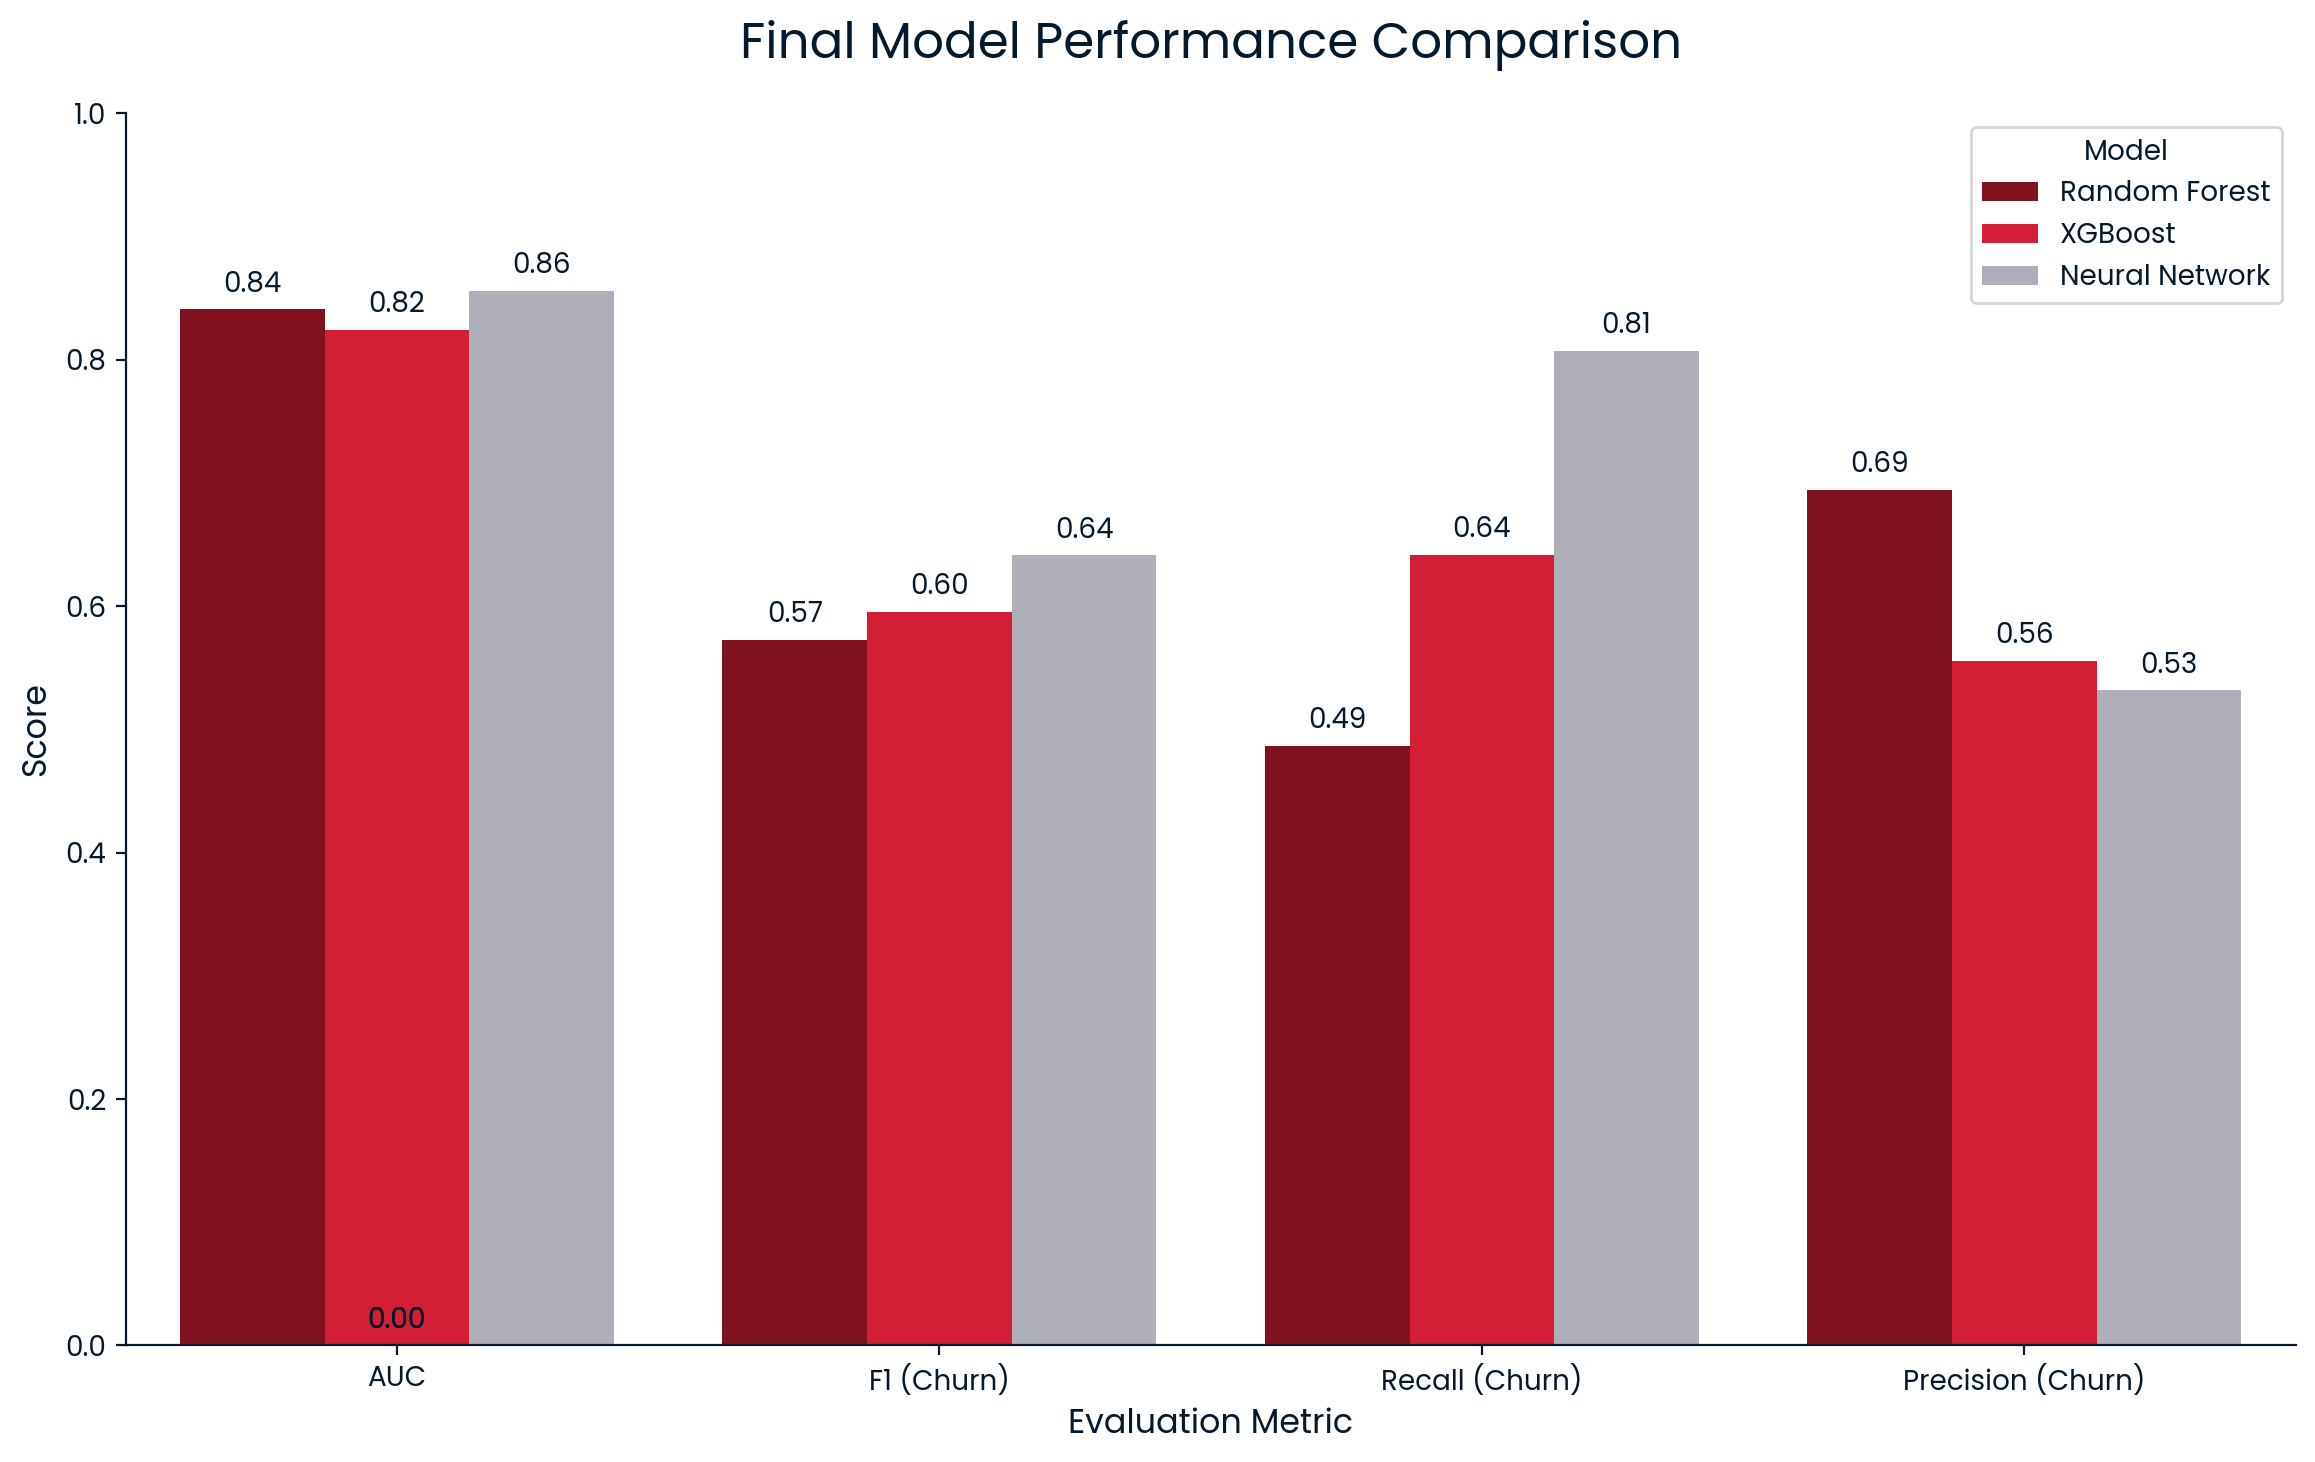

In [7]:
# Convert results dictionary to a DataFrame for easier plotting
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create the plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model', 
                 palette=['#910010', '#F00120', '#ACAEBA', '#E3001E']) # A palette derived from our brand colors

# Add annotations
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Customize and save
plt.title('Final Model Performance Comparison', fontsize=18, pad=20)
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title='Model', fontsize=10)
sns.despine()

# Save the figure to a PNG file
output_filename = 'figures/model_performance_comparison.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"\nChart saved successfully as '{output_filename}'")

plt.show()

The NN scored better in AUC, Recall, and F1 score but lower in Precision. While this indicates a better performance in churn detection, it also results in a higher false-positive rate.

# Part 2: Model Interpretation with SHAP and Customer Profiles

### Interpretation with SHAP

SHAP values tell us how much each feature pushes the model's output from the average prediction (or base value) to the final prediction.

The **beeswarm** plot visualizes the distribution of SHAP values for each feature, allowing you to see if a feature's value (represented by color) correlates with its impact.

The **bar plot** provides a simpler, aggregated view by showing the average absolute SHAP value for each feature, which helps to rank them by overall importance.

The **waterfall plot** provides a detailed explanation for a single prediction. It shows the journey from the average prediction to the final prediction for that specific instance. Each bar in the plot represents a feature's contribution, either increasing or decreasing the prediction, so you can trace exactly why the model arrived at that particular output. This is crucial for debugging and building trust in the model's decisions.

SHAP values shape: (200, 33)
X_test_sample shape: (200, 33)


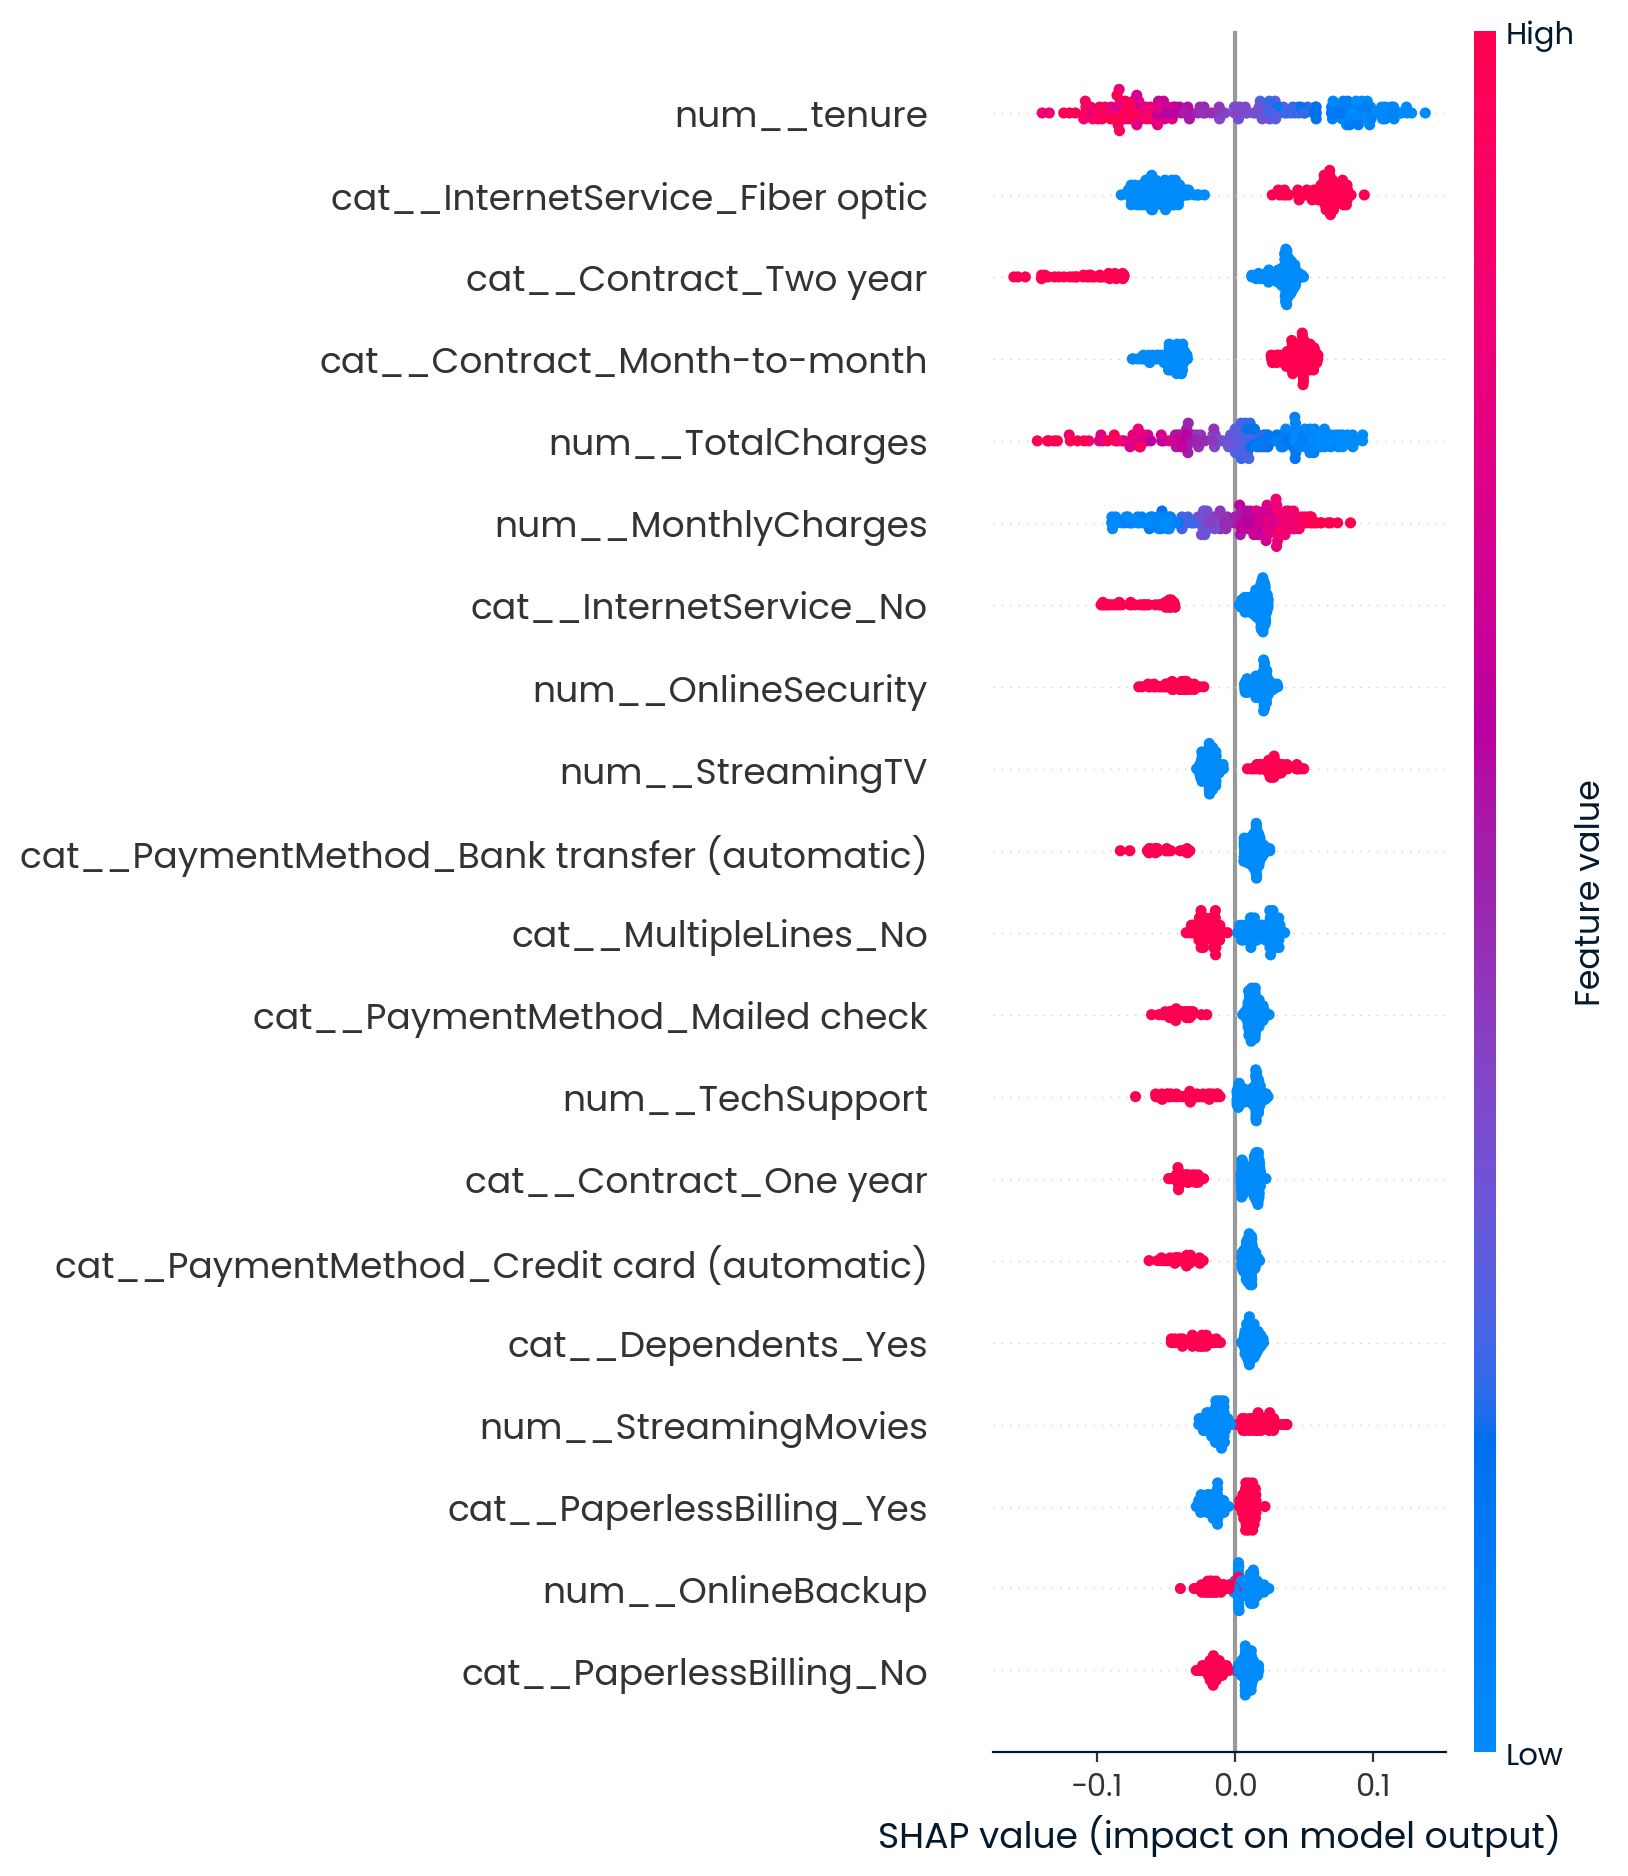

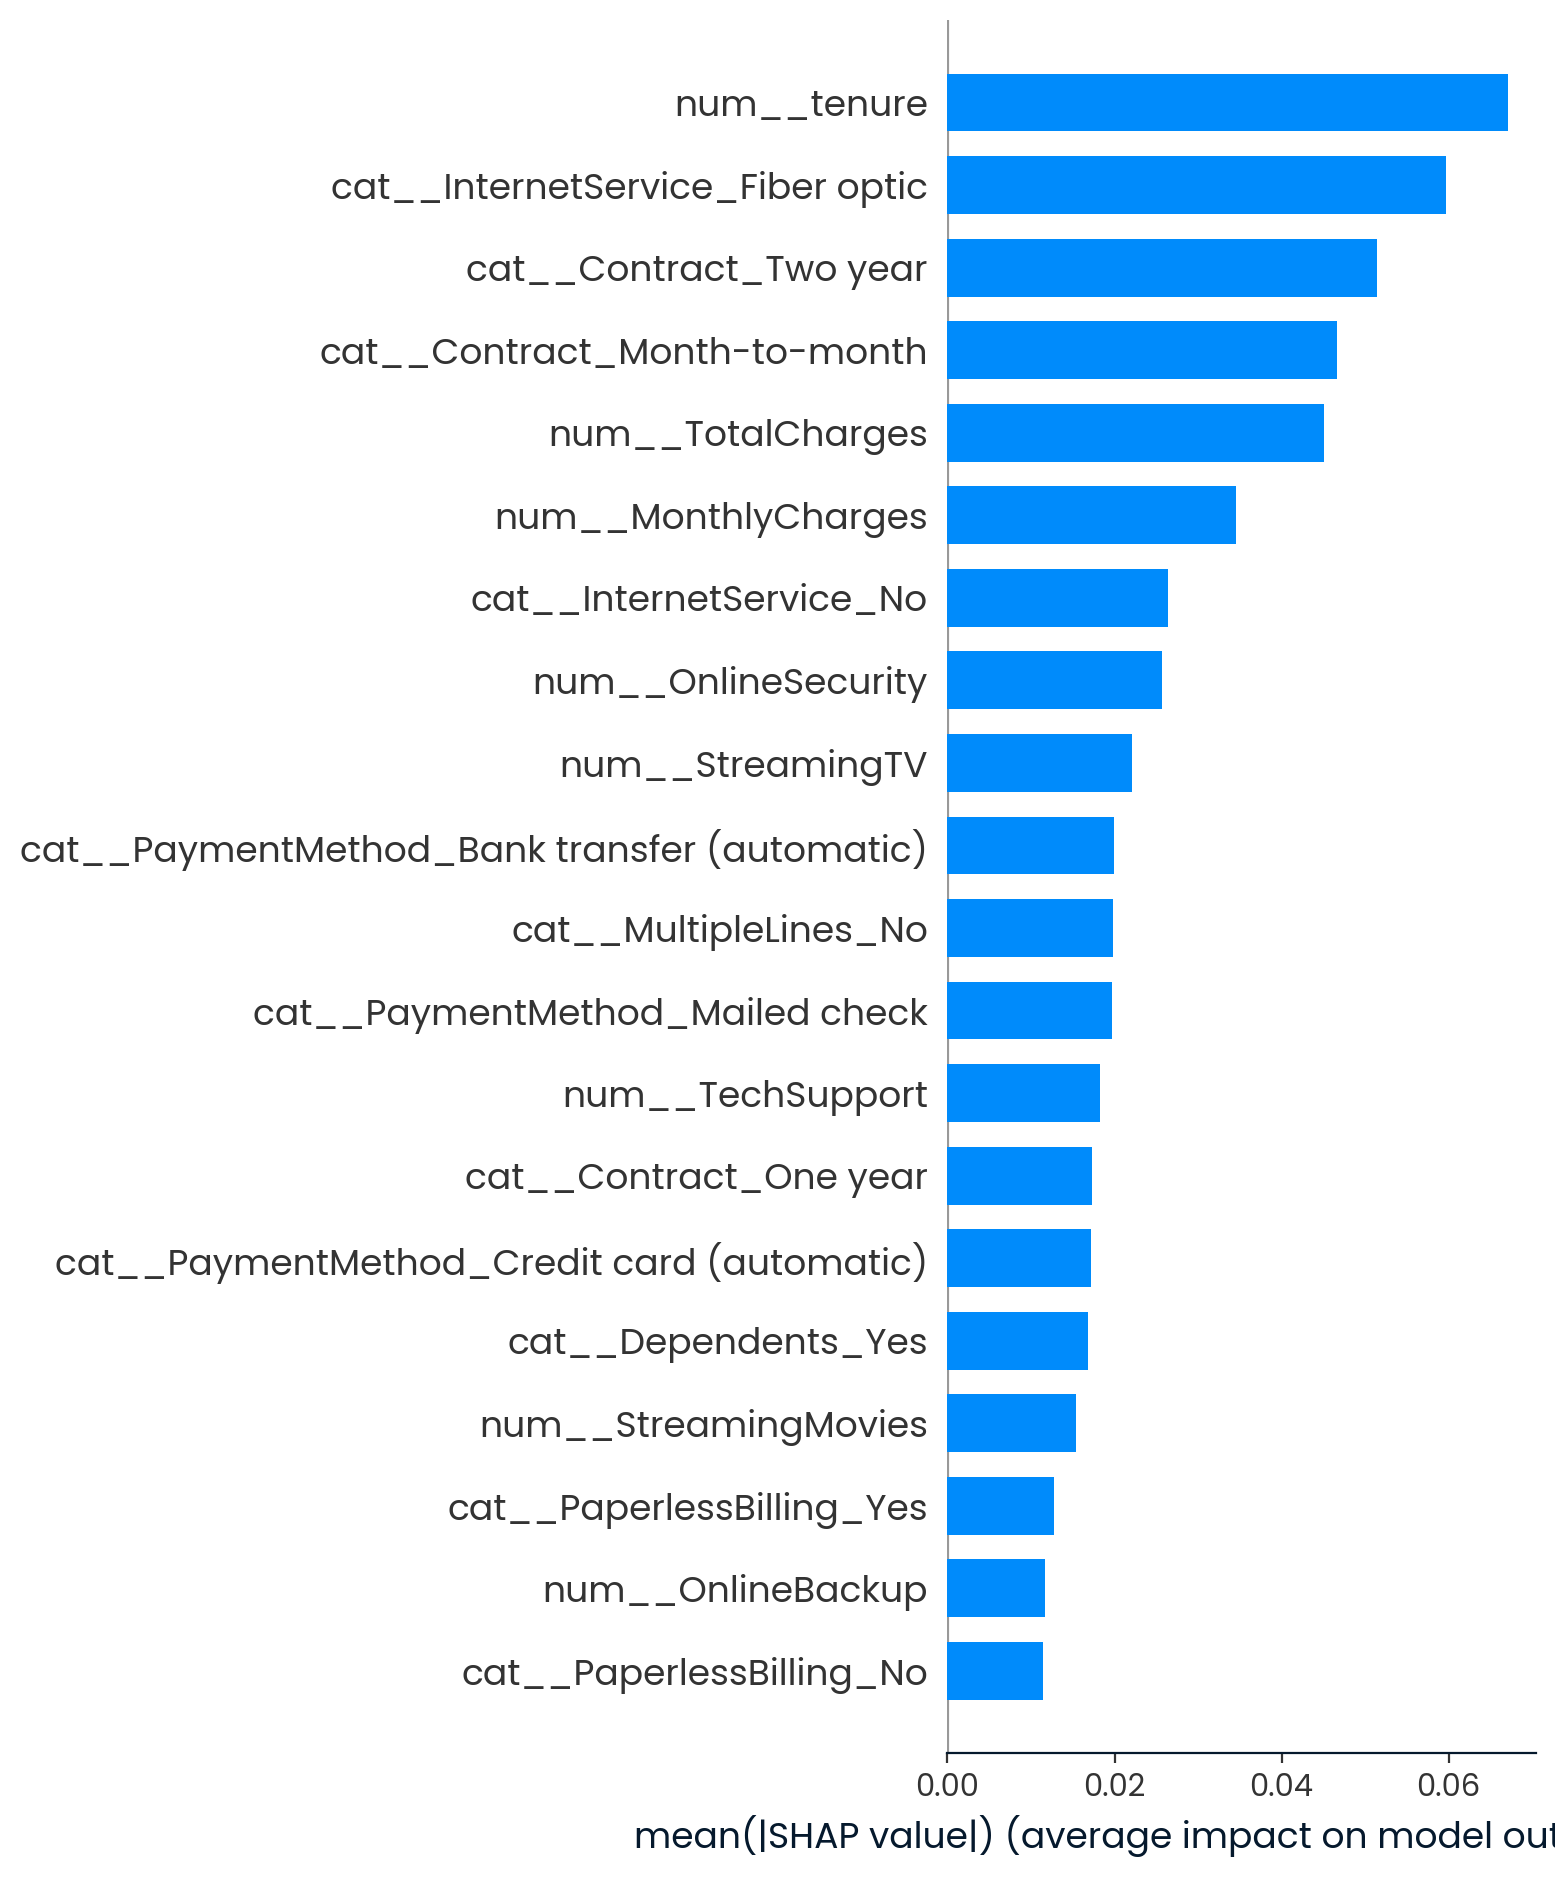

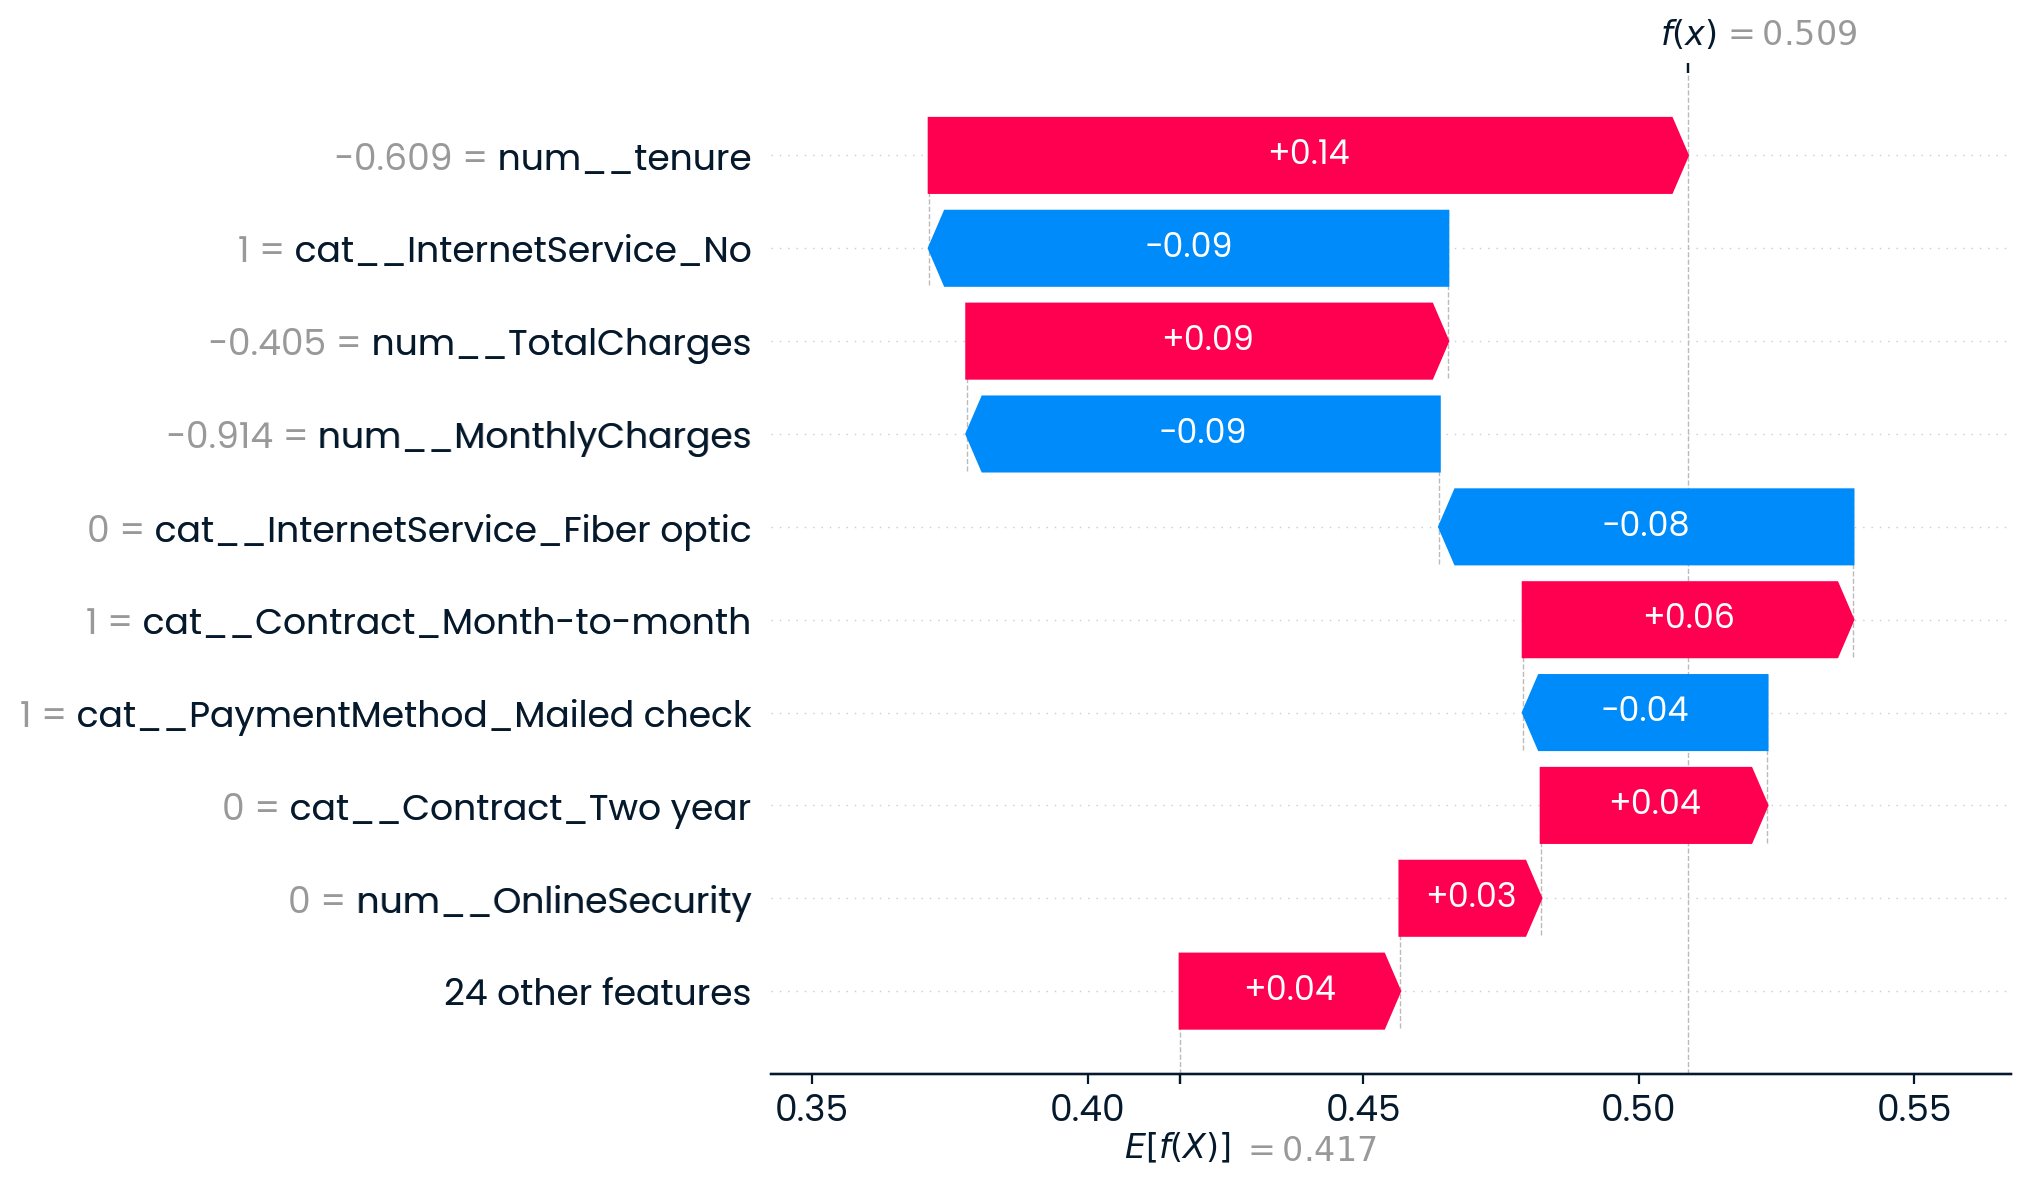

In [ ]:
# Take a sample for faster SHAP calculation
X_test_sample = X_test_processed[:200]

# Create the DeepExplainer
explainer = shap.DeepExplainer(nn_model, X_train_processed[:200])

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

# --- Handle single-output NN DeepExplainer output ---
if isinstance(shap_values, list):
    shap_values = np.array(shap_values[0])  # take first output

# --- Reshape (n_samples, n_features, 1) -> (n_samples, n_features) if needed ---
if shap_values.ndim == 3 and shap_values.shape[2] == 1:
    shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

print("SHAP values shape:", shap_values.shape)
print("X_test_sample shape:", X_test_sample.shape)

# --- Feature names ---
num_features = shap_values.shape[1]  # automatically get number of features
feature_names = preprocessor.get_feature_names_out()  # flat list
assert shap_values.shape[1] == len(feature_names)

# --- Summary plot (beeswarm) ---
plt.figure()  # Create a new figure
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names)
plt.savefig("figures/shap_plot_beeswarm.png", bbox_inches="tight", dpi=300)
plt.close()

# --- Summary bar plot (bar)---
plt.figure()  # Create a new figure
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, plot_type="bar")
plt.savefig("figures/shap_plot_bar.png", bbox_inches="tight", dpi=300)
plt.close()

i = 0  # index of the instance

# Convert SHAP values and features to NumPy arrays
sv = np.array(shap_values[i], dtype=float)
x = np.array(X_test_sample[i], dtype=float)

# Ensure expected_value is a scalar
expected_value = explainer.expected_value
if isinstance(expected_value, (list, np.ndarray, tf.Tensor)):
    expected_value = float(np.array(expected_value)[0] if isinstance(expected_value, (list, np.ndarray)) else expected_value.numpy())

# Generate Matplotlib-based waterfall plot
plt.figure()  # Create a new figure
shap.waterfall_plot(
    shap.Explanation(
        values=sv,
        base_values=expected_value,
        data=x,
        feature_names=feature_names
    )
)
plt.savefig("figures/shap_plot_waterfall.png", bbox_inches="tight", dpi=300)
plt.close()

### Creating Loyalty Profiles

Now we segment customers into six distinct profiles, allowing us to move beyond one-size-fits-all marketing. Four of these are high-risk segments requiring immediate retention actions, while two are low-risk segments representing opportunities for growth and advocacy.

- **High-Risk Segments (Proactive Retention Needed)**
The Freedom Seeker: These customers are on a month-to-month contract, making them highly susceptible to competitor offers. To retain them, offer exclusive discounts to incentivize an upgrade to a longer-term plan.

- **The New & Uncertain:** With a low tenure (under 12 months), these recent customers are still evaluating their services. The focus here should be on demonstrating value through enhanced onboarding and offering a welcome gift to create "stickiness."

- **The At-Risk VIP:** These are high-revenue customers whose churn risk is driven by high monthly charges or issues with premium services. Address their value concerns by offering a complimentary high-touch plan review or a value-added "thank you" gift.

- **General Churn Risk:** This group has no single dominant churn driver, but rather a combination of small issues. A broad, universally appealing goodwill offer—such as a complimentary internet speed boost—is the best way to rebuild their satisfaction.

- **Low-Risk Segments (Opportunities for Growth)**
The Loyal Champion: Your most secure customers, cemented by high tenure (36+ months) or a long-term contract. The goal is to reward their loyalty and transform them into brand advocates with exclusive gifts and referral programs.

- **The Stable Customer:** These customers are currently satisfied but not deeply committed. Nurture them toward "Champion" status by reinforcing the value of their services and offering small incentives to encourage a longer contract.

In [ ]:
churn_threshold = 0.5
sample_size = 200

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Distribution of Customer Loyalty Profiles (from sample):
loyalty_profile
Stable Customer       61
General Churn Risk    54
Loyal Champion        48
At-Risk VIP           23
New & Uncertain       13
Freedom Seeker         1
Name: count, dtype: int64


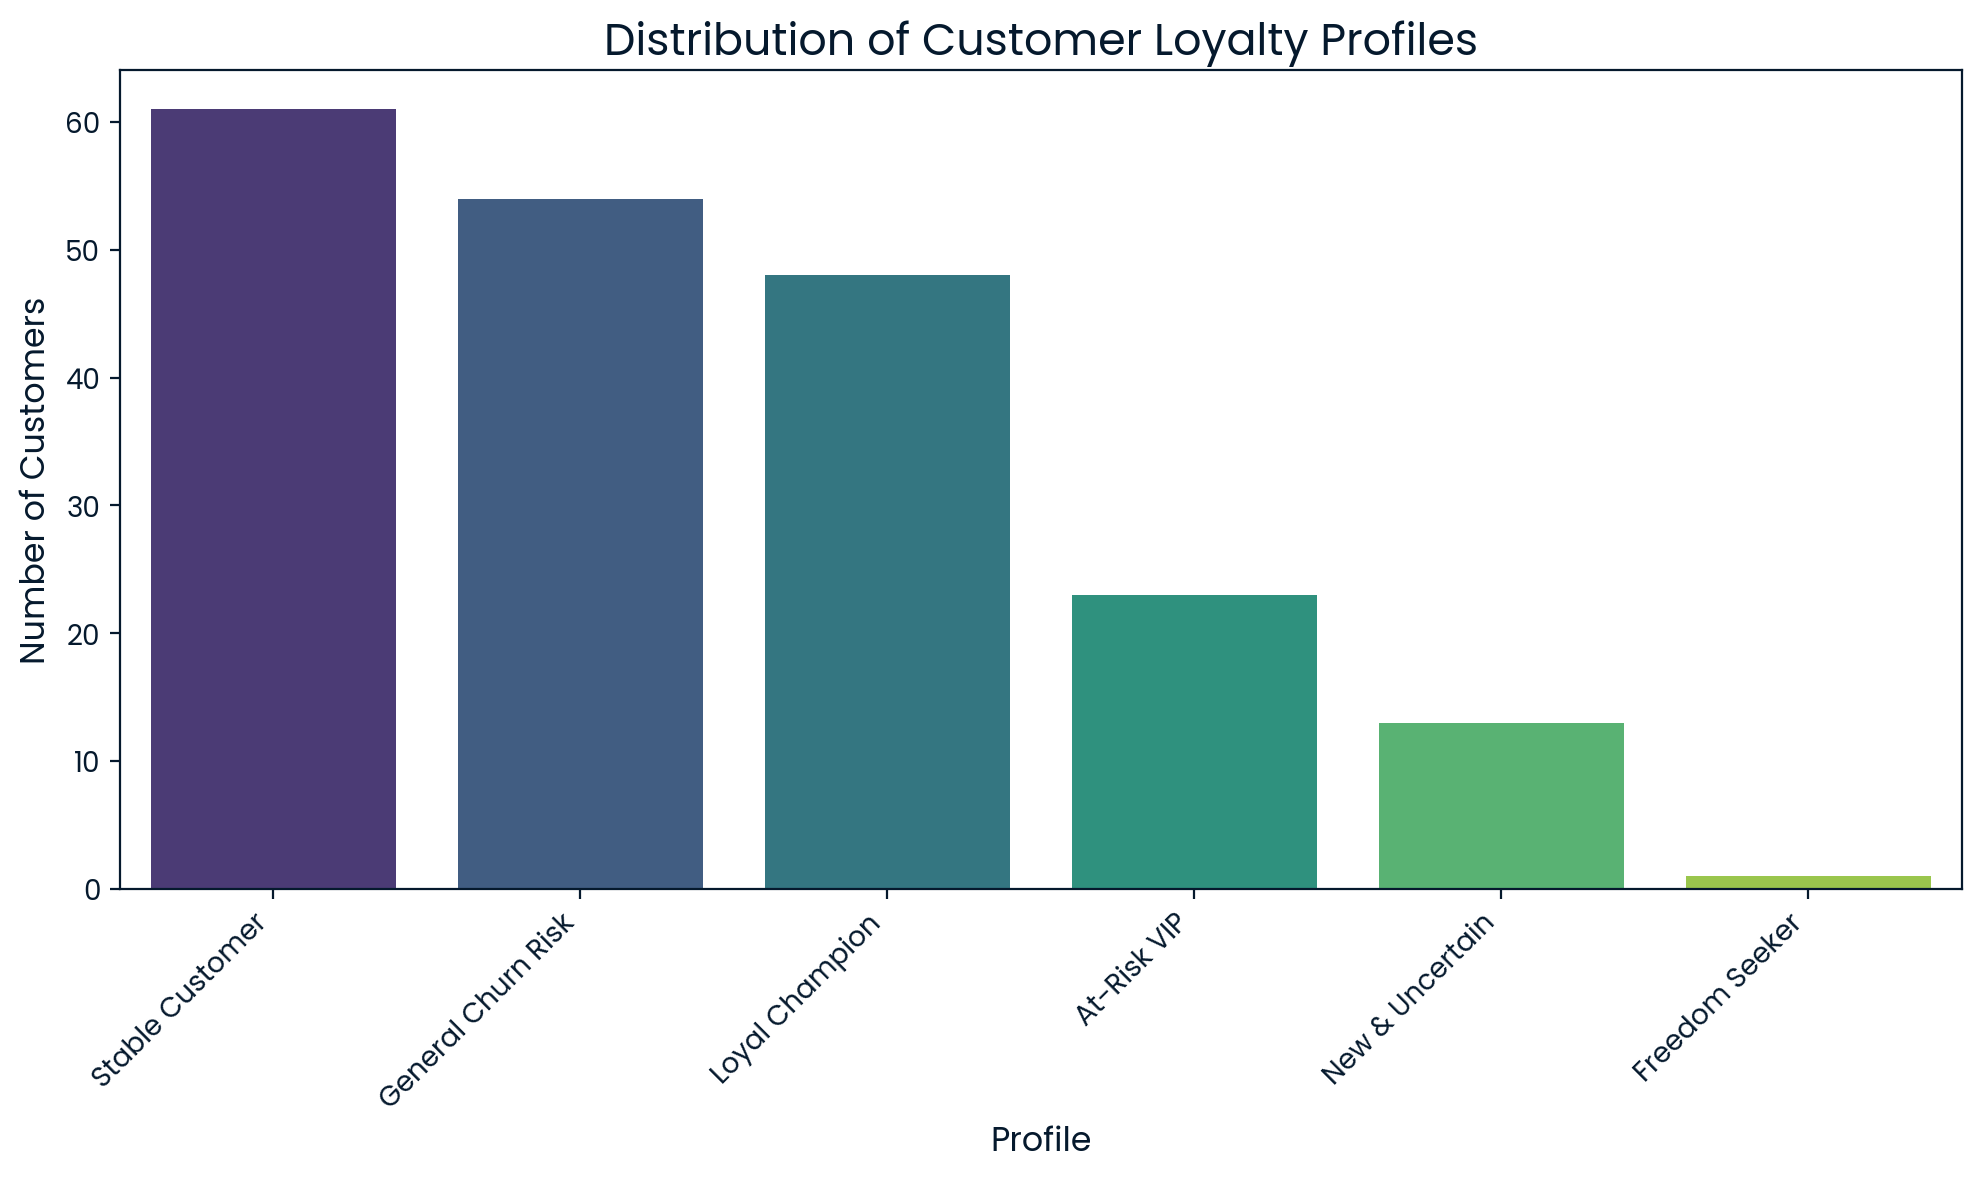

In [ ]:
# We use the raw, unprocessed sample as the base for our final profiles DataFrame
 
if 'X_test_sample_raw' not in locals():
    X_test_sample_raw = shap.sample(X_test, sample_size)
results_df = X_test_sample_raw.copy()

# Predict probabilities for this specific sample
processed_sample = preprocessor.transform(X_test_sample_raw)
sample_probabilities = nn_model.predict(processed_sample).flatten()
results_df['churn_probability'] = sample_probabilities

# --- Create a Correctly Labeled SHAP DataFrame ---

# THE FIX: Get the processed feature names directly from the preprocessor
processed_feature_names = preprocessor.get_feature_names_out()

# Create the SHAP DataFrame with the correct 45 column names and the correct index
# `shap_values` was calculated on the raw sample in the previous step
shap_df = pd.DataFrame(shap_values, columns=processed_feature_names, index=X_test_sample_raw.index)


# --- Identify the Primary Driver for each Customer ---

def get_primary_driver(row):
    """Finds the feature with the highest absolute SHAP value for a customer."""
    abs_shap = row.abs()
    primary_driver_feature = abs_shap.idxmax()
    primary_driver_value = row[primary_driver_feature]
    return pd.Series([primary_driver_feature, primary_driver_value], index=['primary_driver', 'driver_shap_value'])

driver_df = shap_df.apply(get_primary_driver, axis=1)

# --- Combine the DataFrames ---
# Join `results_df` and `driver_df`
final_profiles_df = pd.concat([results_df, driver_df], axis=1)


# --- Define and Assign Customer Personas ---

def assign_loyalty_profile(row):
    """Assigns a persona based on churn probability and the processed primary driver."""
    prob = row['churn_probability']
    driver = row['primary_driver']
    tenure = row['tenure']
    
    # High-Risk Profiles
    if prob > churn_threshold:
        if 'Contract_Month-to-month' in driver:
            return "Freedom Seeker"
        elif 'tenure' in driver and tenure <= 12:
            return "New & Uncertain"
        elif 'InternetService_Fiber optic' in driver or 'MonthlyCharges' in driver:
            return "At-Risk VIP"
        else:
            return "General Churn Risk"
            
    # Low-Risk Profiles
    else:
        if ('Contract_Two year' in driver or 'Contract_One year' in driver) or \
           ('tenure' in driver and tenure >= 36):
            return "Loyal Champion"
        else:
            return "Stable Customer"

final_profiles_df['loyalty_profile'] = final_profiles_df.apply(assign_loyalty_profile, axis=1)


# --- Analyze and Display the Segments ---

print("\nDistribution of Customer Loyalty Profiles (from sample):")
profile_counts = final_profiles_df['loyalty_profile'].value_counts()
print(profile_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=profile_counts.index, y=profile_counts.values, palette='viridis')
plt.title('Distribution of Customer Loyalty Profiles', fontsize=16)
plt.xlabel('Profile', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("figures/loyalty_profiles.png", bbox_inches="tight")
plt.show()

Export Profiles Dataset 

In [10]:
# Save the DataFrame to a CSV file
final_profiles_df.to_csv('data/loyalty_profiles.csv', index=False)

# Display the first few rows of the DataFrame
final_profiles_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn_probability,primary_driver,driver_shap_value,loyalty_profile
3551,Female,0,No,Yes,1,Yes,No,Fiber optic,0,0,0,0,0,1,Month-to-month,Yes,Electronic check,79.60,79.60,0.859122,num__tenure,0.137671,New & Uncertain
5941,Female,0,No,No,36,No,No phone service,DSL,0,1,0,1,0,0,Month-to-month,Yes,Bank transfer (automatic),34.85,1267.20,0.337634,cat__Contract_Two year,-0.137474,Loyal Champion
527,Male,0,Yes,Yes,58,Yes,Yes,Fiber optic,0,1,0,1,1,0,One year,Yes,Credit card (automatic),94.70,5430.35,0.225377,num__tenure,0.115088,Loyal Champion
1141,Male,0,No,Yes,6,Yes,No,No,0,0,0,0,0,0,Month-to-month,Yes,Mailed check,20.20,98.35,0.421761,cat__Contract_Two year,-0.119695,Loyal Champion
4508,Female,0,Yes,Yes,22,Yes,No,No,0,0,0,0,0,0,Month-to-month,No,Mailed check,19.90,400.30,0.216001,cat__InternetService_Fiber optic,0.065205,Stable Customer
